## Breast Cancer Classification - BUSI dataset

## Import Library

In [1]:
#import library
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

# Data Split - 70:15:15

In [4]:
#SKIP 
import os
#Crate folder data split 
def create_data_split():
    #Base directory 
    base_dir = 'data_split'
    os.makedirs(base_dir, exist_ok=True)

    #Directories for train, test, and validation
    train_dir = base_dir + '/train'
    test_dir = base_dir + '/test'
    val_dir = base_dir + '/val'
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    #class 
    classes = ['malignant', 'benign', 'normal']
    for class_name in  classes:
        os.makedirs(os.path.join(train_dir, class_name))
        os.makedirs(os.path.join(test_dir, class_name))
        os.makedirs(os.path.join(val_dir, class_name))
    
    return train_dir, test_dir, val_dir


In [ ]:
import glob
import shutil
from sklearn.model_selection import train_test_split

def split(source_path='Dataset_BUSI_with_GT', train_ratio=0.7, test_ratio=0.15, val_ratio=0.15): 
    train_dir, test_dir, val_dir = create_data_split()
    classes = ['malignant', 'benign', 'normal']
    
    for class_name in classes:
        class_path = os.path.join(source_path, class_name)
        all_file = [f for f in glob.glob(os.path.join(class_path, '*.png')) 
                    if not f.endswith('_mask.png') and not f.endswith('_mask_1.png')]

        train_files, val_files = train_test_split(all_file, train_size=train_ratio)
        val_files, test_files = train_test_split(val_files, test_size=val_ratio/(val_ratio + test_ratio))

        for f in train_files:
            shutil.copy2(f, os.path.join(train_dir, class_name, os.path.basename(f)))
        for f in val_files:
            shutil.copy2(f, os.path.join(val_dir, class_name, os.path.basename(f)))
        for f in test_files:
            shutil.copy2(f, os.path.join(test_dir, class_name, os.path.basename(f)))

        print(f"Class: {class_name}")
        print(f"Total files: {len(all_file)}")
        print(f"Training files: {len(train_files)}")
        print(f"Validation files: {len(val_files)}")
        print(f"Test files: {len(test_files)}\n")

    return train_dir, test_dir, val_dir

# Call split function
train_dir, test_dir, val_dir = split(source_path='Dataset_BUSI_with_GT', train_ratio=0.7, test_ratio=0.15, val_ratio=0.15)
 

Class: malignant
Total files: 210
Training files: 147
Validation files: 31
Test files: 32

Class: benign
Total files: 438
Training files: 306
Validation files: 66
Test files: 66

Class: normal
Total files: 133
Training files: 93
Validation files: 20
Test files: 20



# Set Device - used GPU for compute

In [2]:
# Set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} (GPU: {torch.cuda.is_available()})")

Using device: cuda (GPU: True)


# Config Basic parameters

In [6]:
#Config parameters
data_dir = 'data_split'
train_dir = ('data_split/train')
test_dir = ('data_split/test')
val_dir = ('data_split/val')

batch_size = 32
num_classes = 3
Epochs = 80
img_size = (224, 224) #Include Architectures 
learning_rate = 0.001

# Class weight 'balance'-  data imbalance

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import os 
#Class weights calculation 
# Collect labels for training data
train_labels = []
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for img in os.listdir(class_path):
        train_labels.append(class_name)

print("Training labels:", train_labels)
print("Total Label",len(train_labels))
print("Class begin Label",(train_labels.count('benign')))
print("Class normal Label",(train_labels.count('normal')))
print("Class malignant Label",(train_labels.count('malignant')))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# # Convert class weights to a tensor
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", weights)

Training labels: ['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'b

# Data Augmentation

In [9]:
# *ToTenser = shape (C x H x W) in the range [0.0, 1.0] 
from torchvision import transforms
#Basic
# transforms_train = transforms.Compose([
#     transforms.Resize(img_size),
#     transforms.RandomHorizontalFlip(), 
#     transforms.ToTensor(),
#     transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Normalization of ImageNet
# #make data normalization rang [0, 1], model easy to learn. decrease problem: parameters bigger or smaller than 1, model hard to learn 
# ])

# Advanced ************************************
# Enhancement Data Augmentation
transforms_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transforms_val)
test_dataset = datasets.ImageFolder(test_dir, transform=transforms_val)

# Print dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}
print(f"Dataset sizes: {dataset_sizes}")

#Compress data
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2,)   
}

Dataset sizes: {'train': 546, 'val': 117, 'test': 118}


# Dynamic sampling - oversampling minority class 
(ทำให้โมเดลเห็นSetที่มีข้อมูลน้อยบ่อยขึ้น)

In [10]:
from torch.utils.data import WeightedRandomSampler

malignant_multiplier = 1.5 # ทำให้เห็น malignant class มากขึ้น ? เท่า

def get_dynamic_sampler(dataset, malignant_multiplier):  
    # malignant_multiplier is used to increase the weight of the malignant class 
    # 1.0 means no change, 2.0 means double the weight of the malignant class
    
    # Count samples per class
    targets = np.array(dataset.targets)
    class_sample_count = np.array([np.sum(targets == t) for t in np.unique(targets)])
    
    # Inverse frequency for each class
    weight = 1. / class_sample_count
    
    # Increase weight for malignant class (assuming it's index 0)
    weight[0] *= malignant_multiplier  # Multiply malignant weight by 2
    
    # Assign weight to each sample
    samples_weight = np.array([weight[t] for t in targets])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    return sampler

# Create DataLoader with weighted sampler
dataloaders['train'] = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=get_dynamic_sampler(train_dataset, malignant_multiplier),
    num_workers=2
)

print(dataloaders['train'])
# Check if the dataloaders are working
for phase in ['train', 'val', 'test']:
    print(f"{phase.capitalize()} DataLoader:")
    for images, labels in dataloaders[phase]:
        print(f"  Batch size: {images.size(0)}, Labels(first batch): {labels}")
        break

Train DataLoader:
  Batch size: 32, Labels(first batch): tensor([0, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0,
        2, 0, 0, 2, 1, 0, 2, 0])
  Batch size: 32, Labels(first batch): tensor([0, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0,
        2, 0, 0, 2, 1, 0, 2, 0])
Val DataLoader:
Val DataLoader:
  Batch size: 32, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
  Batch size: 32, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Test DataLoader:
Test DataLoader:
  Batch size: 32, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
  Batch size: 32, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


# Get single batch - get from dataloader [Test]

Batch Shape: torch.Size([32, 3, 224, 224])
Data Type: torch.float32
Min: -2.1179039478302, Max: 2.640000104904175
Mean: -0.7732, Std: 1.0789
Number of batches in each split:
- Train: 18
- Val: 4
- Test: 4
Class to Index Mapping:
{'benign': 0, 'malignant': 1, 'normal': 2}

Class Names (in order of indices):
['benign', 'malignant', 'normal']

Samples per class:
benign: 306 images
malignant: 147 images
normal: 93 images

Samples per class:
benign: 306 images
malignant: 147 images
normal: 93 images
Image stats - Min: 0.000, Max: 0.847, Mean: 0.179
Image stats - Min: 0.000, Max: 1.000, Mean: 0.312
Image stats - Min: 0.000, Max: 1.000, Mean: 0.358
Image stats - Min: 0.000, Max: 0.865, Mean: 0.177
Image stats - Min: 0.000, Max: 0.921, Mean: 0.220
Image stats - Min: 0.000, Max: 0.847, Mean: 0.179
Image stats - Min: 0.000, Max: 1.000, Mean: 0.312
Image stats - Min: 0.000, Max: 1.000, Mean: 0.358
Image stats - Min: 0.000, Max: 0.865, Mean: 0.177
Image stats - Min: 0.000, Max: 0.921, Mean: 0.220


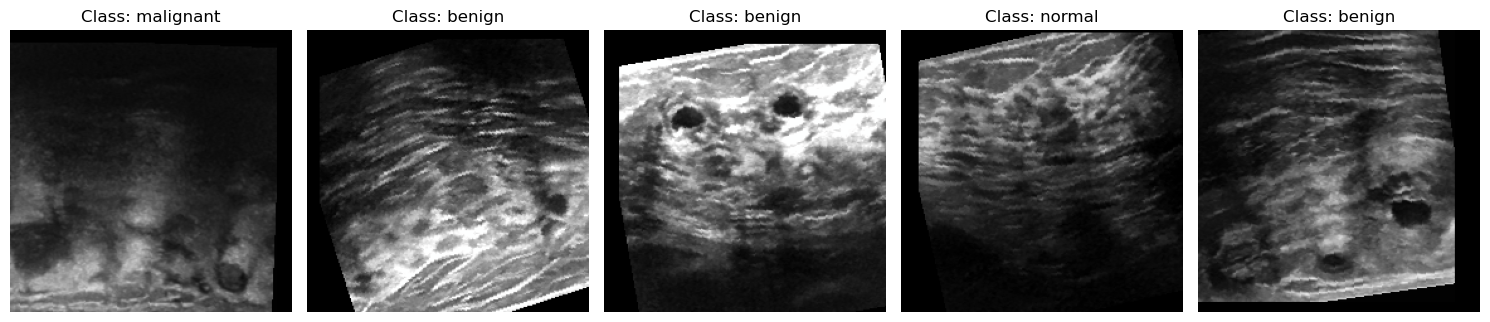

In [11]:
# Get a single batch from the DataLoader
train_batch, train_labels = next(iter(dataloaders['train']))  # Fetch first batch and labels

# Print batch information
print(f"Batch Shape: {train_batch.shape}")
print(f"Data Type: {train_batch.dtype}")
print(f"Min: {train_batch.min()}, Max: {train_batch.max()}")
print(f"Mean: {train_batch.mean():.4f}, Std: {train_batch.std():.4f}")
print(f"Number of batches in each split:")
print(f"- Train: {len(dataloaders['train'])}")
print(f"- Val: {len(dataloaders['val'])}")
print(f"- Test: {len(dataloaders['test'])}")

# Print class mapping
print("Class to Index Mapping:")
print(train_dataset.class_to_idx)

# Print class names in order
print("\nClass Names (in order of indices):")
print(train_dataset.classes)

# Count samples per class
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset:
    class_counts[train_dataset.classes[label]] += 1

print("\nSamples per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

def visualize_batch(dataloader, num_images=5):
    # Get batch of images and labels
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Get class names from the dataset
    class_names = dataloader.dataset.classes
    
    # Create a figure with subplots and show images
    plt.figure(figsize=(15, 4))
    
    for i in range(num_images):
        # Convert tensor to numpy and transpose to (H,W,C)
        img = images[i].numpy().transpose(1, 2, 0)
        
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        gamma = 1.2
        img = np.power(img, gamma)
        print(f"Image stats - Min: {img.min():.3f}, Max: {img.max():.3f}, Mean: {img.mean():.3f}")
        # Create subplot
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'Class: {class_names[labels[i]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a batch of images
visualize_batch(dataloaders['train'])


# Model setup

In [26]:
from torchvision.models import resnet50 ,ResNet50_Weights
def setup_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Freeze early layers
    for param in list(model.parameters())[:-6]:
        param.requires_grad = False
    
    # Modified classifier with stronger regularization
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Increased dropout
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model.to(device)

model = setup_model()
print(f"Number of layers in ResNet50: {len(list(model.children()))}")
print(f'Total parameters : {sum(p.numel() for p in model.parameters())}')
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of layers in ResNet50: 10
Total parameters : 24690755
Trainable parameters: 2235907


In [9]:
from torchvision.models import resnet50 ,ResNet50_Weights
#1. Define model
def setup_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Modify final layer for 3-class problem
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
        # nn.Softmax(dim=1)  #Softmax for multi-class classification
        # nn.Linear(in_features, 3) #Maps features to 3 output logits
        # nn.LogSoftmax(dim=1)  # LogSoftmax for multi-class classification (if using CrossEntropyLoss, this is not needed during training, but can be used during inference
    )
    
    return model.to(device)

model = setup_model()

print(model)
print(f"Number of layers in ResNet50: {len(list(model.children()))}")
print(f'Total parameters : {sum(p.numel() for p in model.parameters())}')
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Focal loss - Bad, low score  

In [14]:
#Focal Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    This is a more robust and complete implementation of Focal Loss.
    It handles multi-class cases and the alpha parameter correctly.
    """
    # def __init__(self, alpha=0.25, gamma=2.0, reduction='mean',):
    def __init__(self, alpha=1, gamma=3, class_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        # self.reduction = reduction
        # use class weights
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        # inputs: model predictions of shape [N, C]
        # targets: ground truth of shape [N]
        
        # First, compute the raw cross-entropy loss without any reduction
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        #class weights
        ce_loss = F.cross_entropy(inputs, targets, reduction='none',weight=self.class_weights)
        
        # Then, compute the probability of the correct class (p_t)
        # pt = exp(-ce_loss)
        pt = torch.exp(-ce_loss)
        
        # This is the core of Focal Loss.
        # It computes the modulating factor (1 - pt)^gamma
        # and multiplies it with the cross-entropy loss.
        focal_loss = (1 - pt)**self.gamma * ce_loss
        
        # Apply the alpha-balancing factor if alpha is specified
        if self.alpha is not None:
            # Create the alpha tensor on the same device as the inputs
            alpha_t = torch.full_like(focal_loss, self.alpha)
            
            # For each target, select the correct alpha weight.
            # In binary classification, this selects `alpha` for the positive class
            # and `1-alpha` for the negative class if you set alpha as a tensor [alpha, 1-alpha].
            # For simplicity here, we assume a single alpha for the foreground class.
            # A more advanced version might take a tensor of alphas for each class.
            
            # Get the ground truth classes
            t_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
            # For positive class (1), weight is alpha. For negative class (0), weight is 1-alpha.
            # This is a common way to handle binary alpha balancing.
            # We assume positive class is `1`.
            alpha_factor = torch.where(t_one_hot.bool(), self.alpha, 1. - self.alpha)
            # For multi-class, alpha can be a list/tensor of weights for each class.
            
            # The simplest application (often sufficient) is to just multiply by alpha.
            # This line assumes you're down-weighting the majority class.
            focal_loss = self.alpha * focal_loss

            #class weights
            return focal_loss.mean()

            
        
        # Apply the reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # 'none'
            return focal_loss

# focal_loss = FocalLoss(alpha=0.25, gamma=2.0) #default parameters
focal_loss = FocalLoss(alpha=0.75, gamma=4 , class_weights=weights)#adjustable parameters + class_weights


### Focal for malignant class

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0, class_alphas=[2.0, 1.0, 1.0]):  # Higher alpha for malignant
        super().__init__()
        self.gamma = gamma
        self.class_alphas = torch.tensor(class_alphas).float()
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        # Get alpha weights for each sample based on its class
        alpha_weights = self.class_alphas[targets].to(inputs.device)
        
        focal_loss = (1-pt)**self.gamma * ce_loss
        focal_loss = alpha_weights * focal_loss
        
        return focal_loss.mean()

# Initialize with higher weight for malignant class (index 0)
criterion = FocalLoss(gamma=3.0, class_alphas=[2.0, 1.0, 1.0])

# Loss function and Optimizer

In [27]:
# Define loss function and optimizer
from torch.nn import CrossEntropyLoss

model = setup_model()
# criterion = FocalLoss(gamma=3.0, class_alphas=[2.0, 1.0, 1.0])  # Higher weight for malignant class
criterion = nn.CrossEntropyLoss(weight=weights)  # Use class weights in CrossEntropyLoss
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)   # Lower learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.3,  # Smaller reduction factor
    patience=7,   # More patience
    verbose=True,
    min_lr=1e-6,
    threshold=0.0005,
    cooldown=2,  # Add cooldown period
)

In [16]:
# Adjust scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

# Set Early Stop 

In [28]:
#Early stopping parameters
patience=10

In [29]:
import time
import copy

def train_model(model, criterion, optimizer, dataloaders, num_epochs=Epochs,
 patience=patience, scheduler=scheduler, device=device):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0  

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        # --- Add Gradient Clipping --- 
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_accuracy = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_accuracy'].append(epoch_accuracy.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_accuracy'].append(epoch_accuracy.item())

                if scheduler is not None:
                    if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(epoch_loss)
                    elif isinstance(scheduler, lr_scheduler.StepLR):
                        scheduler.step()

                # Early stopping
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f'No improvement for {epochs_no_improve} epochs.')
                    print(f'Best val acc: {best_accuracy:.4f}')
                    
                    

                if epochs_no_improve >= patience:
                    print(f'Best val acc: {best_accuracy:.4f}')
                    print(f'Early stopping at epoch {epoch+1}')
                    model.load_state_dict(best_model_wts)
                    return model, history

                if epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best accuracy: {best_accuracy:.4f}')

    time_elapsed = time.time() - since
    # print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# Start Train model 

In [30]:
#Train model
model ,history = train_model(model, criterion, optimizer, dataloaders, num_epochs=Epochs , scheduler=scheduler, device=device, patience=patience)

Epoch 1/80
--------------------
train Loss: 0.9955 Acc: 0.4359
train Loss: 0.9955 Acc: 0.4359
val Loss: 1.1957 Acc: 0.2051
New best accuracy: 0.2051
Epoch 2/80
--------------------
val Loss: 1.1957 Acc: 0.2051
New best accuracy: 0.2051
Epoch 2/80
--------------------
train Loss: 0.8642 Acc: 0.5238
train Loss: 0.8642 Acc: 0.5238
val Loss: 1.0879 Acc: 0.4274
New best accuracy: 0.4274
Epoch 3/80
--------------------
val Loss: 1.0879 Acc: 0.4274
New best accuracy: 0.4274
Epoch 3/80
--------------------
train Loss: 0.6746 Acc: 0.6447
train Loss: 0.6746 Acc: 0.6447
val Loss: 0.9624 Acc: 0.5128
New best accuracy: 0.5128
Epoch 4/80
--------------------
val Loss: 0.9624 Acc: 0.5128
New best accuracy: 0.5128
Epoch 4/80
--------------------
train Loss: 0.6863 Acc: 0.6374
train Loss: 0.6863 Acc: 0.6374
val Loss: 1.4194 Acc: 0.4274
No improvement for 1 epochs.
Best val acc: 0.5128
Epoch 5/80
--------------------
val Loss: 1.4194 Acc: 0.4274
No improvement for 1 epochs.
Best val acc: 0.5128
Epoch 5/

# Plot validation loss and Accuracy

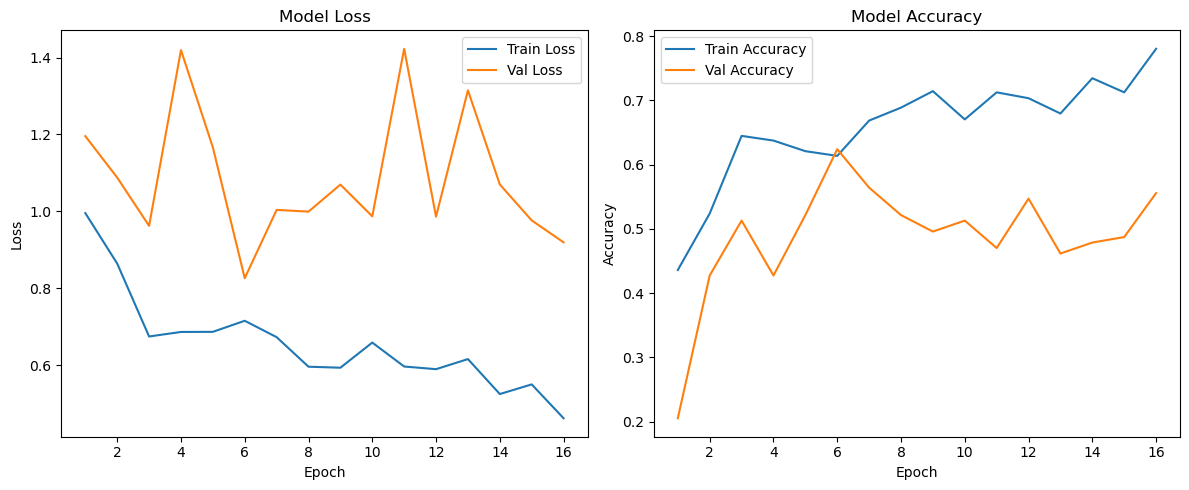

In [31]:
# Plot training and validation loss and accuracy from the training history

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


# Evaluate the model on test set

In [32]:
#  Evaluate the Model on the Test Set
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and labels
test_preds, test_labels = evaluate_model(model, dataloaders['test'])

# Calculate accuracy
test_acc = np.mean(test_preds == test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6017


# Show Report

              precision    recall  f1-score   support

      benign       0.72      0.67      0.69        66
   malignant       0.47      0.44      0.45        32
      normal       0.48      0.65      0.55        20

    accuracy                           0.60       118
   macro avg       0.56      0.58      0.57       118
weighted avg       0.61      0.60      0.60       118



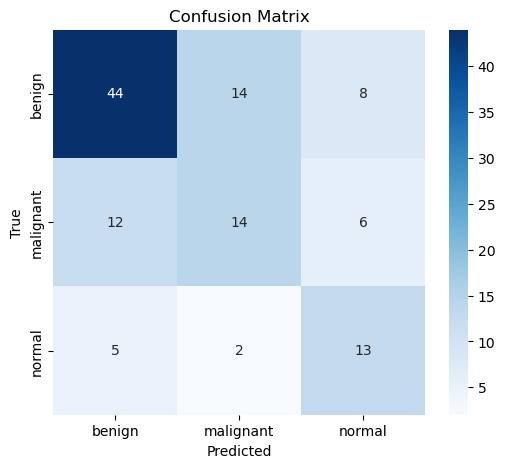

In [33]:
# Show a Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Print classification report
print(classification_report(test_labels, test_preds, target_names=train_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

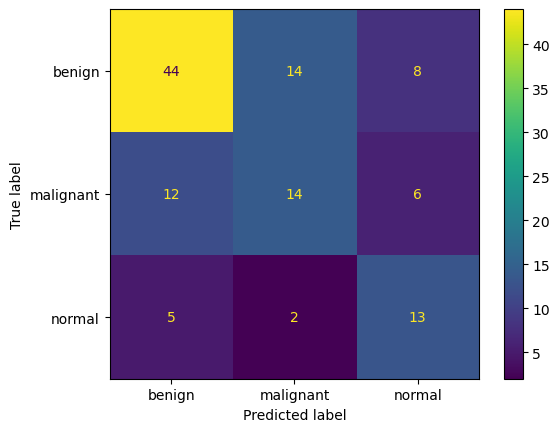

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign','malignant','normal'])
disp.plot()


# Sample some prediction 

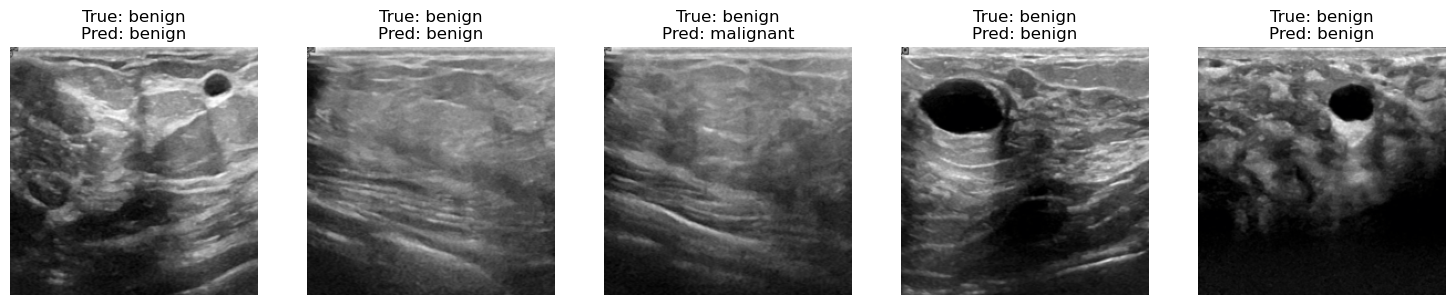

In [40]:
#Visualize Some Predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images_shown = 0
    class_names = dataloader.dataset.classes
    plt.figure(figsize=(15, 3))
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                img = inputs[i].cpu().numpy().transpose(1,2,0)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.subplot(1, num_images, images_shown+1)
                plt.imshow(img)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
                plt.axis('off')
                images_shown += 1

visualize_predictions(model, dataloaders['test'], num_images=5)

In [ ]:
#Save the Model
torch.save(model.state_dict(), 'model_focal.pth')